# Excitable cells as dynamical systems: supplementary lecture

In [1]:
%pylab inline

style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import division

In [3]:
from numba import jit

In [4]:
# This set of parameters corresponds to SNIC
napk_pset = dict(
    I_bias = 0.0,
    El = -80.0,
    Ena = 60.0,
    Ek = -90.0,
    gl = 8.0,
    gna = 20.0,
    gk = 10.0,
    ntau = 1.0,
    minf_vhalf = -20.,
    minfk = 15.,
    ninf_vhalf = -25.,
    ninfk = 5.0
)

SN_off = napk_pset.copy()   # Saddle-Node off limit cycle
superAH = napk_pset.copy()  # Supercritical AH
superAH2 = napk_pset.copy() # Supercritical AH v2
subAH = napk_pset.copy()    # subcritical AH
subAH2 = napk_pset.copy()   # subcritical AH (idential to Izhikevich 2007)


SN_off.update(ntau=0.16)
superAH.update(ninf_vhalf=-44,minf_k=10.)
superAH2.update(ninf_vhalf=-44, gl=7, gna=19, ninfk=7, minf_k=10)
subAH.update(gl=1.0, gna=4., gk=4., minf_vhalf=-30.,ninf_vhalf=-40., minfk=7.0)
subAH2.update(gl=1.0, gna=4., gk=4., minf_vhalf=-30., minfk=7., ninf_vhalf=-45., El=-78.0,)

In [5]:
@jit
def boltzman(v,vhalf,k):
    return 1./(1.0 + exp((vhalf-v)/k))

def locmax(v,th=-20):
    allmax = where(diff(sign(diff(v)))<=-1)[0]+1
    allmax = [a for a in allmax if v[a]>=th]
    return array(allmax)

In [6]:
from scipy.interpolate import UnivariateSpline as usp

In [7]:
def adams_bashforth(rhs, init_state, dt=0.025, tstart=0, tstop=500,  fnkwargs=None):
    #f_buff = deque()
    if fnkwargs is None:
        fnkwargs = {}
        
    ndim = len(init_state)
    tv = arange(tstart,tstop,dt)
    xout = zeros((len(tv), ndim))
    xout[0] = init_state
    fprev = array(rhs(xout[0], tv[0], **fnkwargs))
    xnew = xout[0] + dt*fprev
    xout[1] = xnew
    for k,t in enumerate(tv[1:-1]):
        xprev,xcurr = xout[k:k+2]
        fnew = array(rhs(xcurr, t,**fnkwargs))
        xnew = xcurr + dt*(3*fnew/2.0 - fprev/2.0)
        fprev = fnew
        xout[k+2] = xnew
    return tv, xout

In [8]:
def I_pulse(tx, amp, start, stop,k=10):
    return amp*0.5*(1 + tanh(k*(tx-start)) * tanh(k*(-tx+stop)))

def I_ramp(tx, k, start=50,stop=1000):
    #return  k*(tx-start)*I_pulse(tx, 1, start, stop)
    return usp(tx, k*(tx-start)*I_pulse(tx, 1, start, stop),s=0)


def make_pulses(tv, npulses=5, period=5, start=100, amp=5, width=1,steep=10.):
    onsets = arange(start, start+npulses*period,period)
    y = np.sum(I_pulse(tv, amp, on, on+width,k=steep) for on in onsets)
    return usp(tv, y, s=0)

def combine_interpolations(tv, signals):
    y = np.sum(s(tv) for s in signals)
    return usp(tv, y, s=0)

class InapkNeuron:
    def __init__(self, **params):
        self.__dict__.update(params)
        self.I_bias = 0
    def minf(self, v):
        return boltzman(v, self.minf_vhalf, self.minfk)
    def ninf(self, v):
        return boltzman(v, self.ninf_vhalf, self.ninfk)
    def ina(self, v):
        return self.gna*self.minf(v)*(v-self.Ena)
    def ik(self, v, n):
        return self.gk*n*(v-self.Ek)
    def ileak(self,v):
        return self.gl*(v-self.El)
    def vnullcline(self, v):
        return (self.I_bias - self.ina(v) - self.ileak(v))/(self.gk*(v-self.Ek))
    def nnullcline(self, v, I=0):
        return self.ninf(v)
                                                  
    def __call__(self, state, t, I_dyn=0):
        v,n = state
        I_app = self.I_bias
        if I_dyn:
            I_app += I_dyn(t)
        dV = I_app - (self.ina(v) + self.ileak(v) + self.ik(v,n))
        dn = (self.ninf(v)-n)/self.ntau
        return np.array([dV, dn])

def inapk_model(state, t, 
                El = -80.0, 
                I_bias = 0,
                I_dyn = 0, 
                Ena = 60.0, 
                Ek = -90.0,
                gl = 8.0,
                gna = 20.0,
                gk = 10.0,
                ntau = 1.0,
                minf_vhalf = -20.,
                minfk = 15.,
                ninf_vhalf = -25.,ninfk = 5.0):
    v,n = state
    minf = boltzman(v, minf_vhalf, minfk)
    ninf = boltzman(v, ninf_vhalf, ninfk)
    dn = (ninf-n)/ntau
    I_app = I_bias #+ I_ramp(t, I_kramp)
    if I_dyn:
        I_app += I_dyn(t)
    dV = I_app - (gna*minf*(v-Ena) + gk*n*(v-Ek) + gl*(v-El))
    return np.array([dV,dn])

(90, 160)

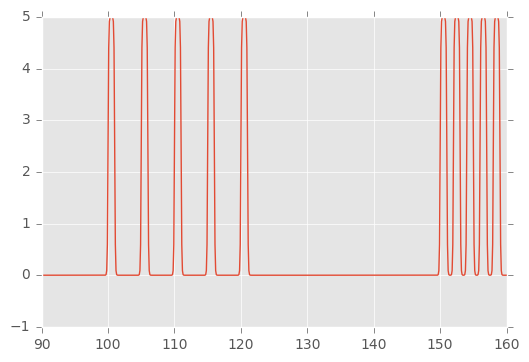

In [9]:
tx = arange(0,1000,0.1)
Ipulses = make_pulses(tx,npulses=5,period=5,width=1)
Ipulses2 = make_pulses(tx,npulses=5,period=2,width=1,start=150)

Iapp =combine_interpolations(tx, (Ipulses, Ipulses2))

plot(tx, Iapp(tx))
xlim(90,160)

In [10]:
Ibias_bif = 4.514
Vrest = -63.8
nrest = boltzman(Vrest, napk_pset['ninf_vhalf'],napk_pset['ninfk'])

#pars = dict(I_bias=4,I_kramp=0.005)

Ipulses = combine_interpolations(tx, 
                                 (make_pulses(tx,amp=10,npulses=10,period=p,start=100+50*k) 
                                  for k,p in enumerate([1.5, 2, 2.5, 3])))

Ipulses2 = combine_interpolations(tx, 
                                 (make_pulses(tx,amp=6,npulses=5,period=p,start=100+(p*5+k*50)) 
                                  for k,p in enumerate([2,  3, 7.4,])))

Ipulses3 = combine_interpolations(tx, [Ipulses2, 
                                       make_pulses(tx, amp=6, start=50,npulses=1),
                                       make_pulses(tx, amp=-6, start=350,npulses=1),
                                       make_pulses(tx, amp=-6, start=300,npulses=1),
                                       make_pulses(tx, amp=6, start=355,npulses=1)])


                                      
pars=dict(I_dyn=Ipulses3)

snic_neuron = InapkNeuron(**napk_pset)

snoff_neuron = InapkNeuron(**SN_off)
supAH_neuron = InapkNeuron(**superAH)

subAH_neuron = InapkNeuron(**subAH)
subAH2_neuron = InapkNeuron(**subAH2)

## Threshold manifolds

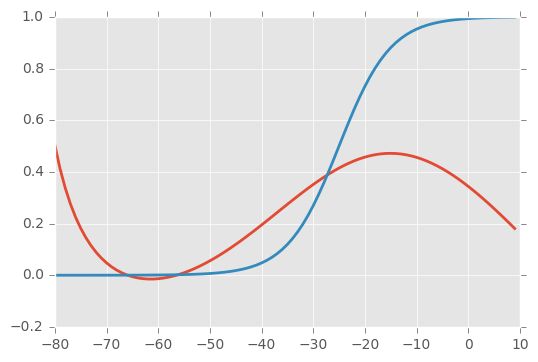

In [12]:
Vv = arange(-80, 10)

snic_neuron.I_bias = 0

plot(Vv, snic_neuron.vnullcline(Vv),lw=2)
plot(Vv, snic_neuron.nnullcline(Vv),lw=2)

In [13]:
def test_init_state(neuron, state,tstop=100):
    tvx, outx = adams_bashforth(neuron, state,tstop=tstop)
    return np.max(outx[:,0])

def test_init_state2(neuron, state,tstop=200):
    tvx, outx = adams_bashforth(neuron, state,tstop=tstop)
    tail = (outx[:,0][tvx>100])
    return amax(tail)-amin(tail)

In [14]:
def prep_phase_portrait(neuron, ax=None):
    if ax is None:
        f,ax = subplots(1,1)
    Vv = arange(-80, 10)
    ax.plot(Vv, neuron.vnullcline(Vv),lw=2,color='#ff6600')
    ax.plot(Vv, neuron.nnullcline(Vv),lw=2,color='#2a7fff')
    setp(ax, ylabel = 'Ik activation', xlabel='membrane potential [mV]')
    ax.axis([-80,10,-0.1,1])
    return ax
    
    

def map_trajectories(neuron, 
                     voltages=linspace(-80,-30,10),
                     activations =  linspace(0, 0.5, 10)):
    ax = prep_phase_portrait(neuron)
    for v in voltages:
        for n in activations:
            _, traj = adams_bashforth(neuron, array([v,n]), tstop=100)
            ax.plot(traj[:,0],traj[:,1], color='k',alpha=0.1)
            ax.plot(traj[0,0],traj[0,1],marker='s',ms=1,mfc='y',mec='y')
            ax.plot(traj[-1,0],traj[-1,1],color='m',marker='.')
            
    

CPU times: user 4.64 s, sys: 16 ms, total: 4.65 s
Wall time: 4.68 s


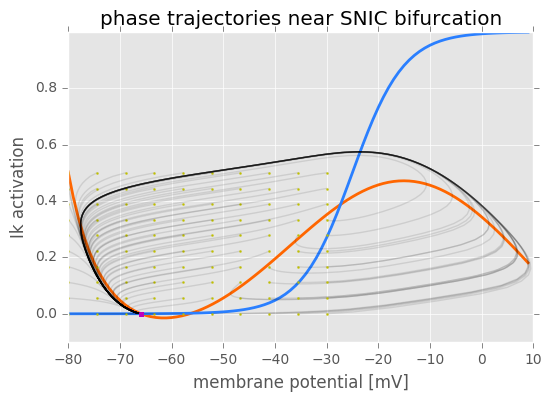

In [15]:

%time map_trajectories(snic_neuron)
title('phase trajectories near SNIC bifurcation')

CPU times: user 4.41 s, sys: 8 ms, total: 4.42 s
Wall time: 4.41 s


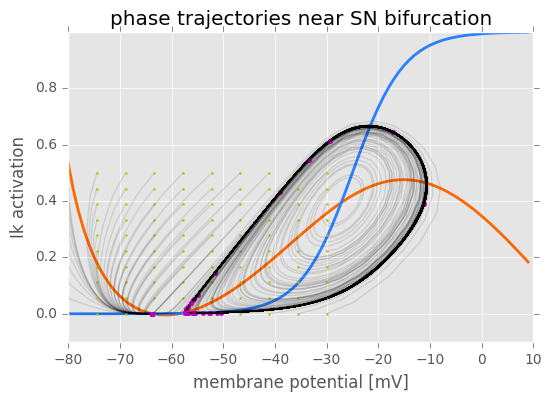

In [16]:
snoff_neuron.I_bias = 3.
%time map_trajectories(snoff_neuron)
title('phase trajectories near SN bifurcation')

In [17]:
superAH

{'Ek': -90.0,
 'El': -80.0,
 'Ena': 60.0,
 'I_bias': 0.0,
 'gk': 10.0,
 'gl': 8.0,
 'gna': 20.0,
 'minf_k': 10.0,
 'minf_vhalf': -20.0,
 'minfk': 15.0,
 'ninf_vhalf': -44,
 'ninfk': 5.0,
 'ntau': 1.0}

In [27]:
supAH2_neuron = InapkNeuron(**superAH2)


supAH2_neuron.I_bias=33


#t,traj = adams_bashforth(supAH2_neuron, [-80,0.1],tstop=200)
#plot(t, traj[:,0])

#prep_phase_portrait(supAH2_neuron)

CPU times: user 4.7 s, sys: 4 ms, total: 4.7 s
Wall time: 4.69 s


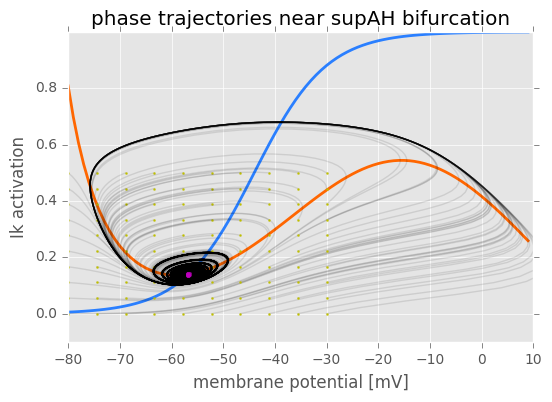

In [19]:
#supAH_neuron.I_bias = 23


%time map_trajectories(supAH2_neuron)
title('phase trajectories near supAH bifurcation')

CPU times: user 4.41 s, sys: 12 ms, total: 4.42 s
Wall time: 4.42 s


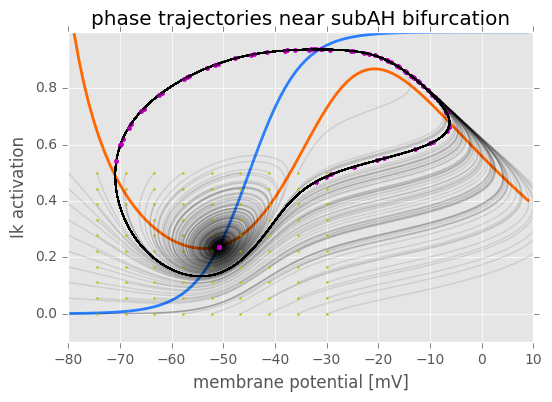

In [20]:
subAH2_neuron.I_bias = 43

%time map_trajectories(subAH2_neuron)

title('phase trajectories near subAH bifurcation')

In [21]:
def map_excitability(neuron,    
                     voltages = linspace(-80,-10,50),
                     activations =  linspace(0, 1., 50),
                     cmap='GnBu',
                     testfn=test_init_state2):
    Vmax = np.zeros((len(activations),len(voltages)))
    for i,v in enumerate(voltages):
        for j,n in enumerate(activations):
            state = array([v,n])
            Vmax[j,i] = testfn(neuron, state)
    
    f,ax = subplots(1,1)
    
    if testfn == test_init_state:
        clim=(-65, 10)
    else:
        clim = (0,50)
        
    extent = extent=[voltages[0],voltages[-1],activations[0], activations[-1]]
    m = ax.imshow(Vmax, aspect='auto',extent=extent, clim=clim,cmap=cmap,origin='lower')
    
    prep_phase_portrait(neuron,ax)

    #if testfn == test_init_state:
    colorbar(m)
    
    ylabel('Ik activation')
    xlabel('membrane potential [mV]')
    ax.axis([-80,10,-0.1,1])
    
    return Vmax

In [24]:
voltages = linspace(-80,-30,100)
#sn_activations = linspace(0,0.2,10)
ah_activations = linspace(0,0.8,100)

CPU times: user 6min 49s, sys: 316 ms, total: 6min 50s
Wall time: 6min 49s
CPU times: user 13min 47s, sys: 540 ms, total: 13min 47s
Wall time: 13min 46s


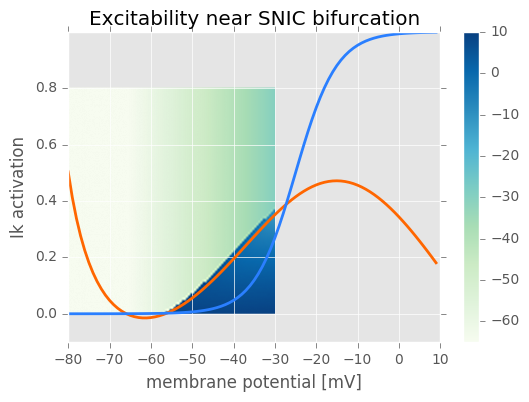

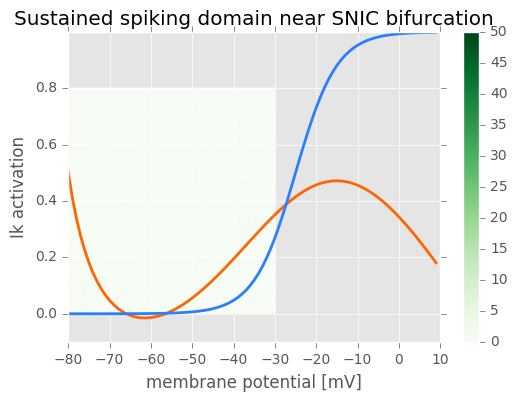

In [25]:
%time Vmax = map_excitability(snic_neuron,voltages=voltages, activations=ah_activations,testfn=test_init_state)
title('Excitability near SNIC bifurcation')

figure()
%time Vmax= map_excitability(snic_neuron,voltages=voltages, activations=ah_activations,  cmap='Greens')
title('Sustained spiking domain near SNIC bifurcation')

CPU times: user 6min 45s, sys: 448 ms, total: 6min 45s
Wall time: 6min 45s
CPU times: user 13min 46s, sys: 640 ms, total: 13min 47s
Wall time: 13min 46s


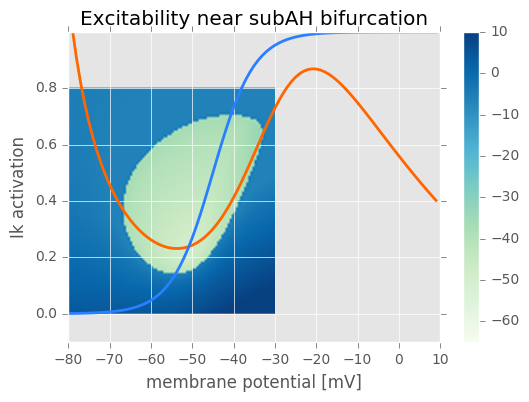

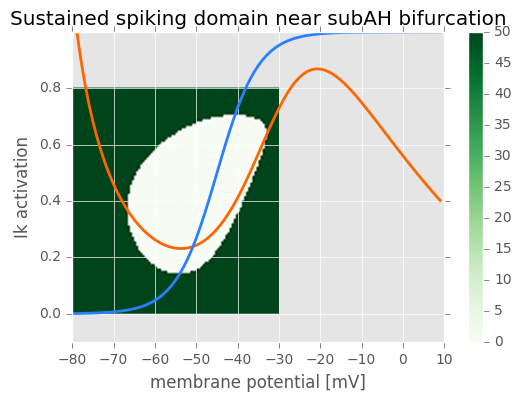

In [26]:
figure()
%time Vmax = map_excitability(subAH2_neuron,voltages=voltages, activations=ah_activations, testfn=test_init_state)
title('Excitability near subAH bifurcation')

figure()
%time Vmax= map_excitability(subAH2_neuron,voltages=voltages, activations=ah_activations,  cmap='Greens')
title('Sustained spiking domain near subAH bifurcation')

CPU times: user 6min 39s, sys: 136 ms, total: 6min 39s
Wall time: 6min 39s
CPU times: user 13min 17s, sys: 600 ms, total: 13min 17s
Wall time: 13min 16s


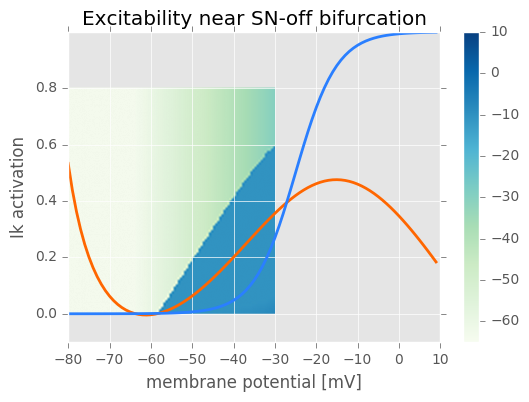

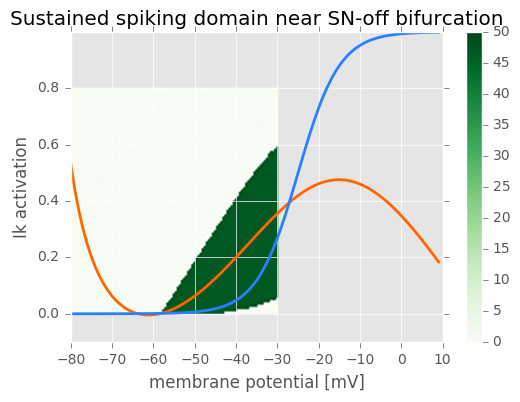

In [27]:
figure()
%time Vmax= map_excitability(snoff_neuron,voltages=voltages, activations=ah_activations,  testfn=test_init_state)
title('Excitability near SN-off bifurcation')

figure()
%time Vmax= map_excitability(snoff_neuron,voltages=voltages, activations=ah_activations,  cmap='Greens')
title('Sustained spiking domain near SN-off bifurcation')

CPU times: user 6min 53s, sys: 404 ms, total: 6min 53s
Wall time: 6min 53s
CPU times: user 14min 2s, sys: 848 ms, total: 14min 3s
Wall time: 14min 2s


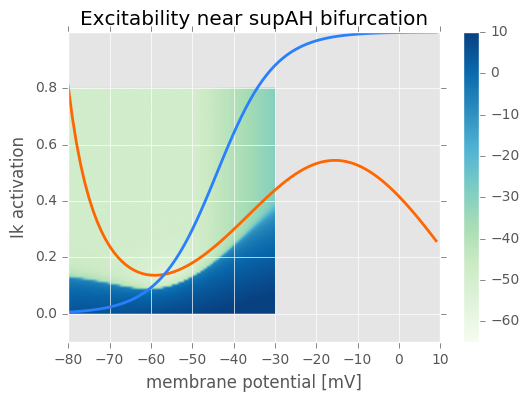

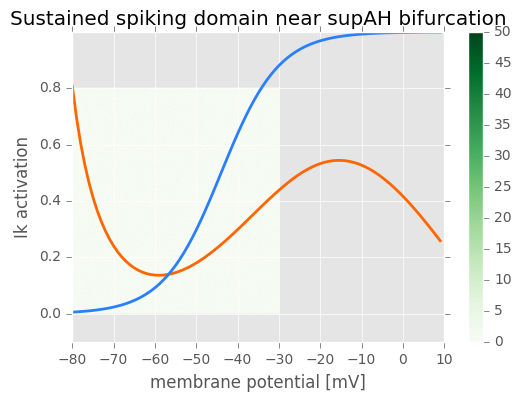

In [28]:

figure()
%time Vmax = map_excitability(supAH2_neuron,voltages=voltages, activations=ah_activations, testfn=test_init_state)
title('Excitability near supAH bifurcation')

figure()
%time Vmax= map_excitability(supAH2_neuron,voltages=voltages, activations=ah_activations,  cmap='Greens')
title('Sustained spiking domain near supAH bifurcation')

## Response to short pulse batches

CPU times: user 1.12 s, sys: 8 ms, total: 1.13 s
Wall time: 1.17 s


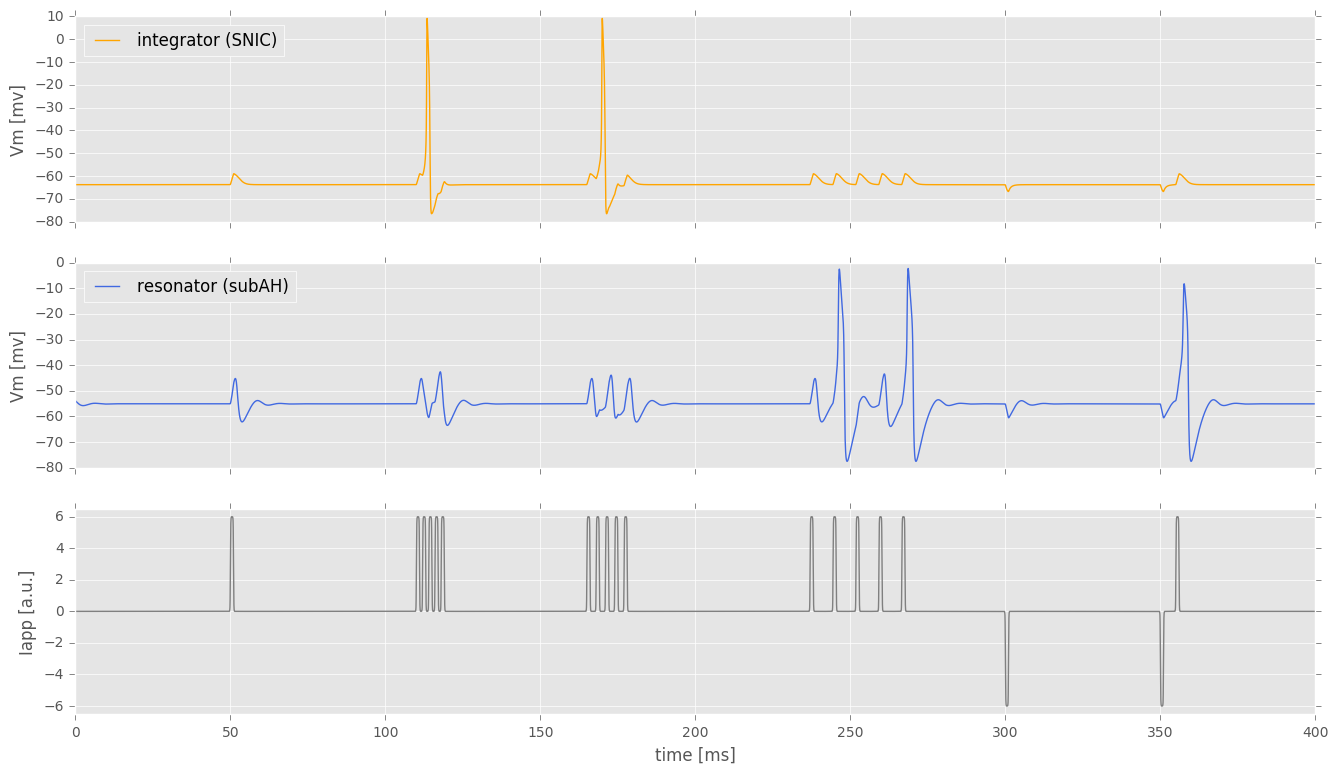

In [16]:
%%time 

init_state = [-63.8, snic_neuron.ninf(-63.8)]
init_state2=[-53.9,  subAH_neuron.ninf(-53.9)]

snic_neuron.I_bias = 3
subAH_neuron.I_bias = 19

tvx, outx = adams_bashforth(snic_neuron, init_state, fnkwargs=pars,tstop=400)
tvx2, outx2 = adams_bashforth(subAH_neuron, init_state2, fnkwargs=pars,tstop=400)

f,axs = subplots(3,1,sharex=True,figsize=(16,9))

axs[0].plot(tvx, outx[:,0],color='orange',label='integrator (SNIC)')
axs[1].plot(tvx2, outx2[:,0],color='royalblue',label='resonator (subAH)')

axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')


axs[2].plot(tvx2, Ipulses3(tvx2),color='gray',)
#xlim(330,360)
ylim(-6.5, 6.5)
axs[0].set_ylabel('Vm [mv]')
axs[1].set_ylabel('Vm [mv]')

ylabel('Iapp [a.u.]')
xlabel('time [ms]')
#axs[1].set_ylim(-60,-50)
savefig('outputs/integrator-vs-resonator-inapk.svg')
#savefig('outputs/integrator-vs-resonator-inapk.p')

# Slow modulation

In [17]:
snic_neuron.I_bias = 0

In [18]:
i_stim =   make_pulses(tx, 8, amp=5, period=100, width=50,steep=0.2)

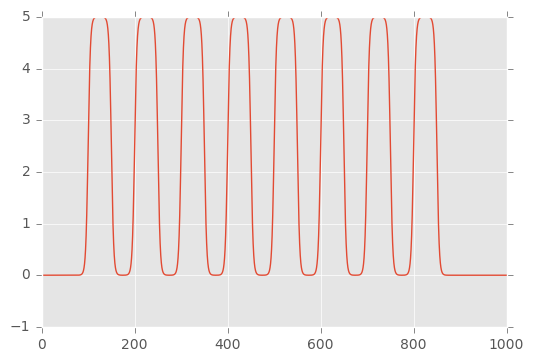

In [19]:
plot(tx, i_stim(tx))

In [20]:
init_state = [-60, 0.01]

In [21]:
def plot_with_i_dyn(neuron, init_tate, stim,tstop=1000,title=""):
    t,traj = adams_bashforth(neuron, init_state, tstop=tstop, fnkwargs=dict(I_dyn=stim))

    figure(figsize=(14,6))

    ax1 = subplot2grid((4,1), (0,0), rowspan=3)
    ax2 = subplot2grid((4,1), (3,0))

    ax1.plot(t, traj[:,0],'royalblue')
    setp(ax1, ylim=(-80,15), xticklabels=[], ylabel='membrane potential [mV]')
    
    ystim = stim(t) + neuron.I_bias
    ax2.plot(t, ystim,'gray')
    
    stim_range = abs(amax(ystim)-amin(ystim))
    ylim = (amin(ystim)-0.1*stim_range, amax(ystim)+0.1*stim_range)
    setp(ax2, ylim=ylim, xlabel='time [ms]', ylabel='I stim [a.u.]')

    ax1.set_title(title)
    #ax1.set_title()

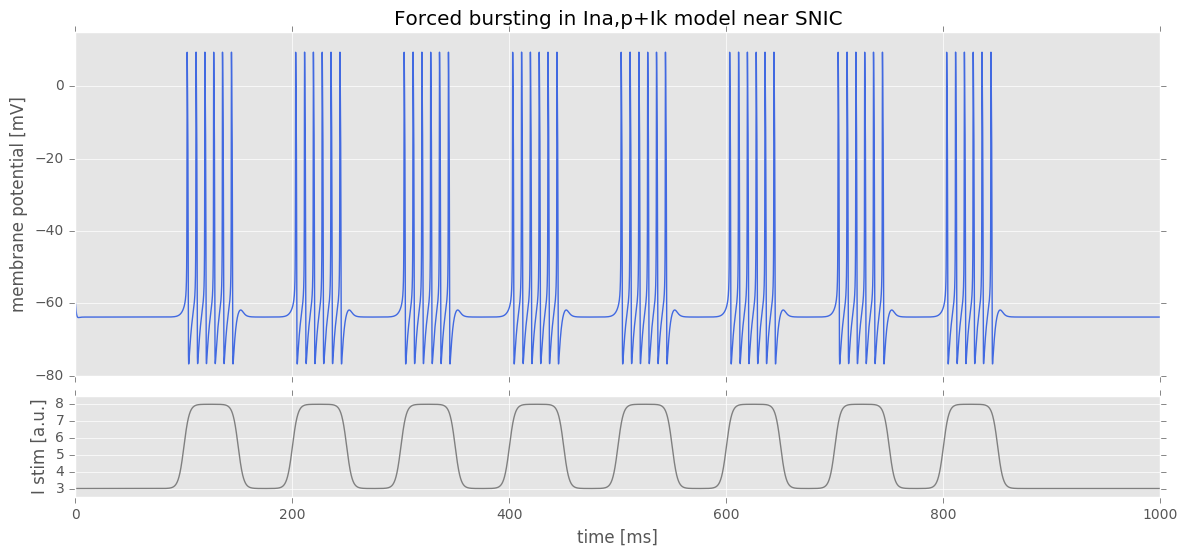

In [22]:
snic_neuron.I_bias=3
plot_with_i_dyn(snic_neuron, init_state, i_stim, title="Forced bursting in Ina,p+Ik model near SNIC")

[None]

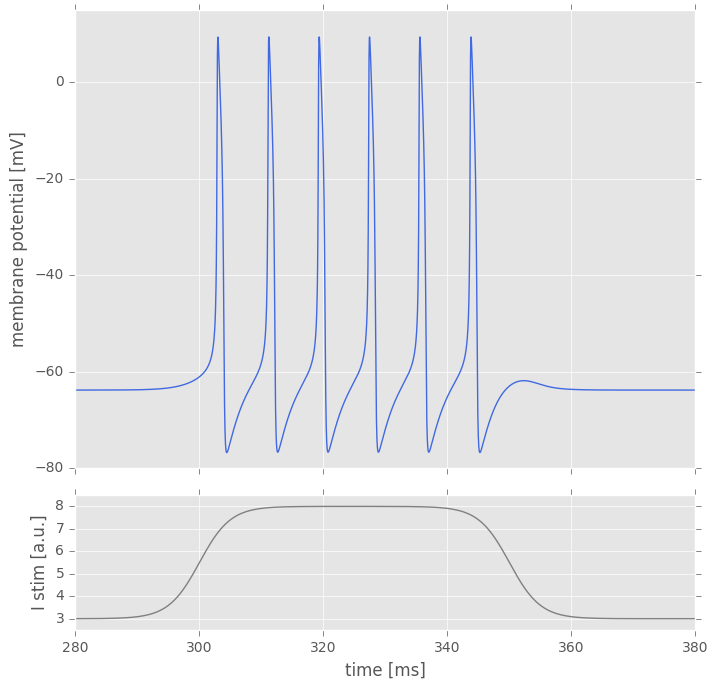

In [23]:
snic_neuron.I_bias=3
plot_with_i_dyn(snic_neuron, init_state, i_stim,title="",tstop=500)
for ax in gcf().axes:
    ax.set_xlim(280,380)
    
for ax in gcf().axes:
    ax.set_xlim(280,380)
    
setp(gcf(), size_inches=(8,8))

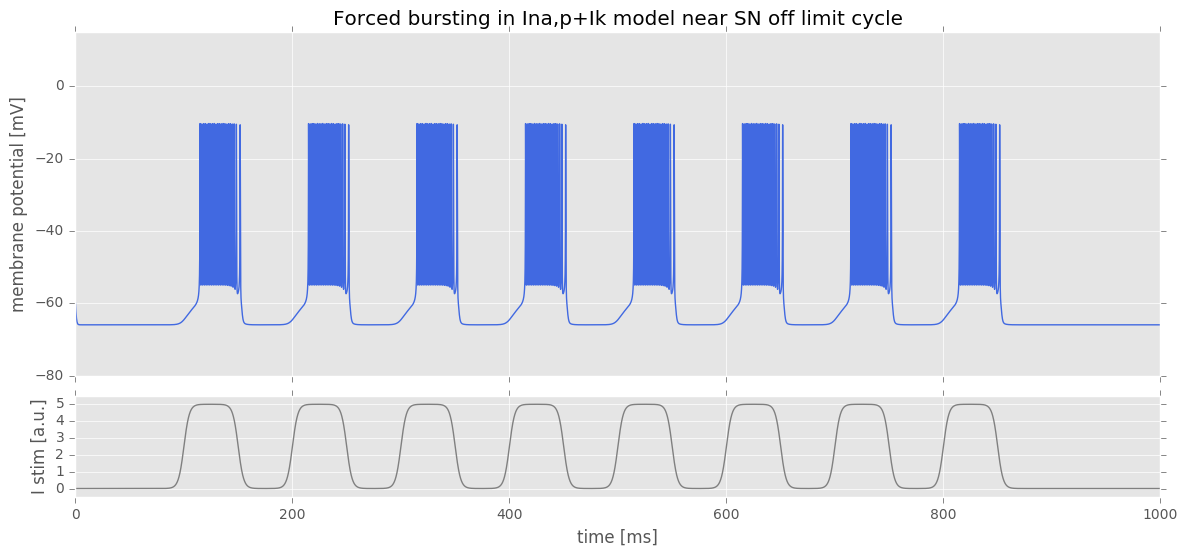

In [24]:
snoff_neuron.I_bias=0
plot_with_i_dyn(snoff_neuron, init_state, i_stim,
                title="Forced bursting in Ina,p+Ik model near SN off limit cycle")

[None]

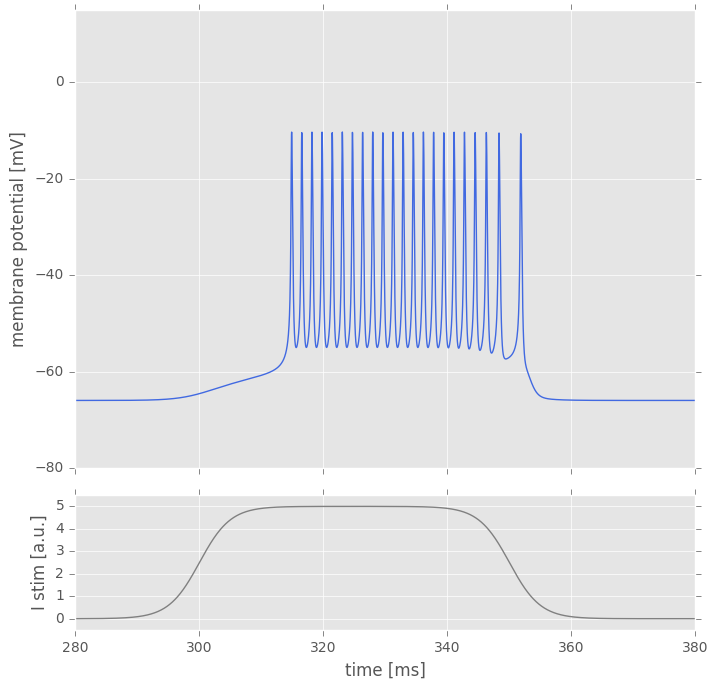

In [25]:
snoff_neuron.I_bias=0
plot_with_i_dyn(snoff_neuron, init_state, i_stim,
                title="")

for ax in gcf().axes:
    ax.set_xlim(280,380)
    
setp(gcf(), size_inches=(8,8))

[ -7.74512914e+01   1.51585553e-03]


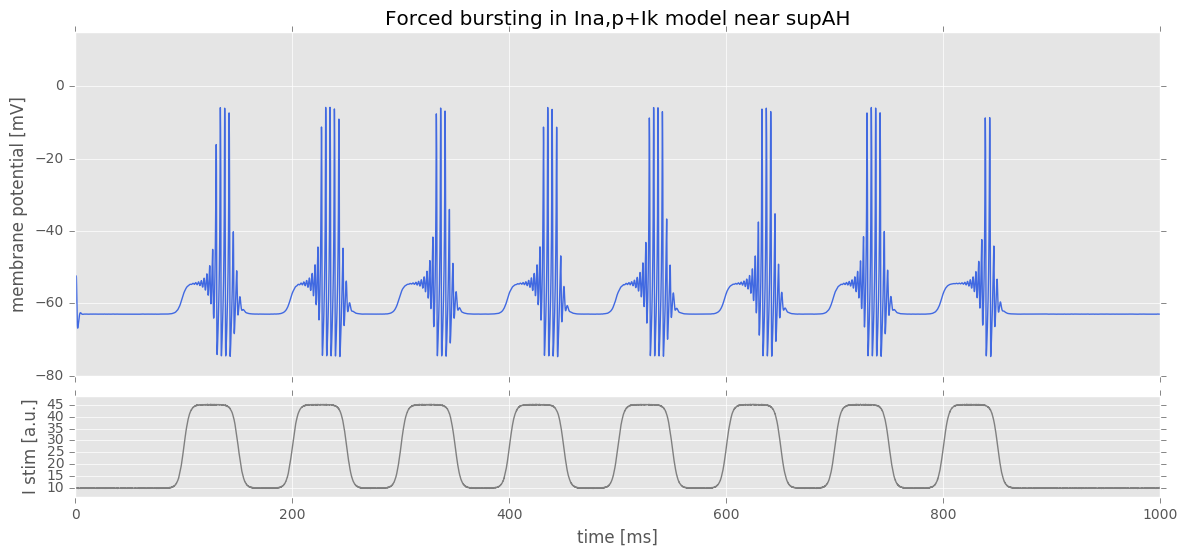

In [28]:
supAH2_neuron.I_bias=10

_,traj = adams_bashforth(subAH2_neuron, [-50.6,0.2459],tstop=200)
init_state_supAH = traj[-1]
print init_state_supAH

plot_with_i_dyn(supAH2_neuron, init_state_supAH, 
                usp(tx,7*i_stim(tx)+0.05*randn(len(tx)),s=0),
                title="Forced bursting in Ina,p+Ik model near supAH")

[None]

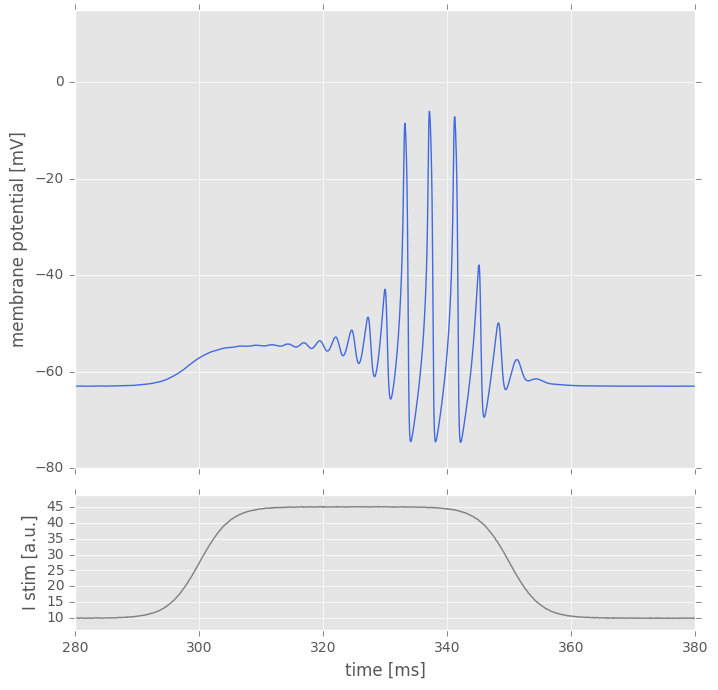

In [29]:
plot_with_i_dyn(supAH2_neuron, init_state_supAH, 
                usp(tx,7*i_stim(tx)+0.05*randn(len(tx)),s=0),
                title="")

for ax in gcf().axes:
    ax.set_xlim(280,380)
    
setp(gcf(), size_inches=(8,8))

[-51.43895255   0.21622702]


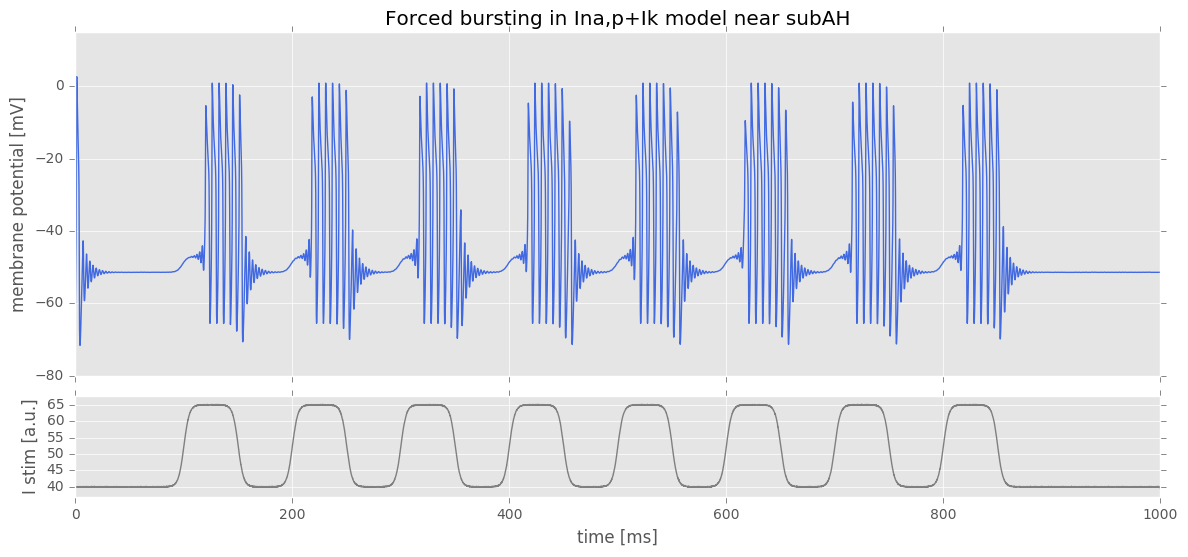

In [30]:
subAH2_neuron.I_bias=40

_,traj = adams_bashforth(subAH2_neuron, [-50.6,0.2459],tstop=200)
init_state_subAH = traj[-1]
print init_state_subAH

plot_with_i_dyn(subAH2_neuron, init_state_subAH, 
                usp(tx,5*i_stim(tx)+0.05*randn(len(tx)),s=0),
                title="Forced bursting in Ina,p+Ik model near subAH")

[None]

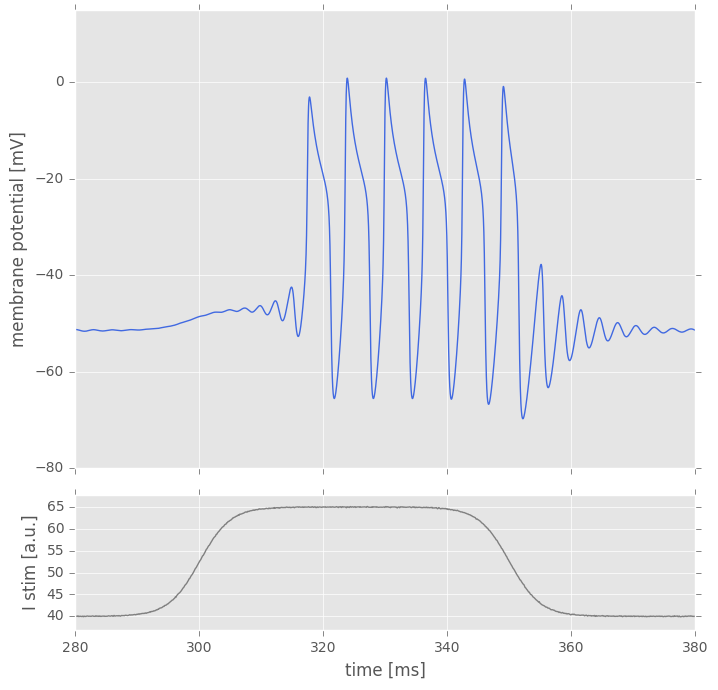

In [43]:
plot_with_i_dyn(subAH2_neuron, init_state_subAH, 
                usp(tx,5*i_stim(tx)+0.05*randn(len(tx)),s=0),
                title="")

for ax in gcf().axes:
    ax.set_xlim(280,380)
    
setp(gcf(), size_inches=(8,8))

# Response to noise

In [49]:
tx[-1]

999.90000000000009

In [50]:
tx = arange(0,100*1000,0.1)
i_stim_noise = usp(tx[::10],randn(len(tx[::10])),s=0)

In [34]:
snoff_neuron.I_bias = 3.9
_,traj = adams_bashforth(snoff_neuron, init_state,tstop=200)
init_state_snoff = traj[-1]


print init_state_snoff

[ -6.27509825e+01   5.25730223e-04]


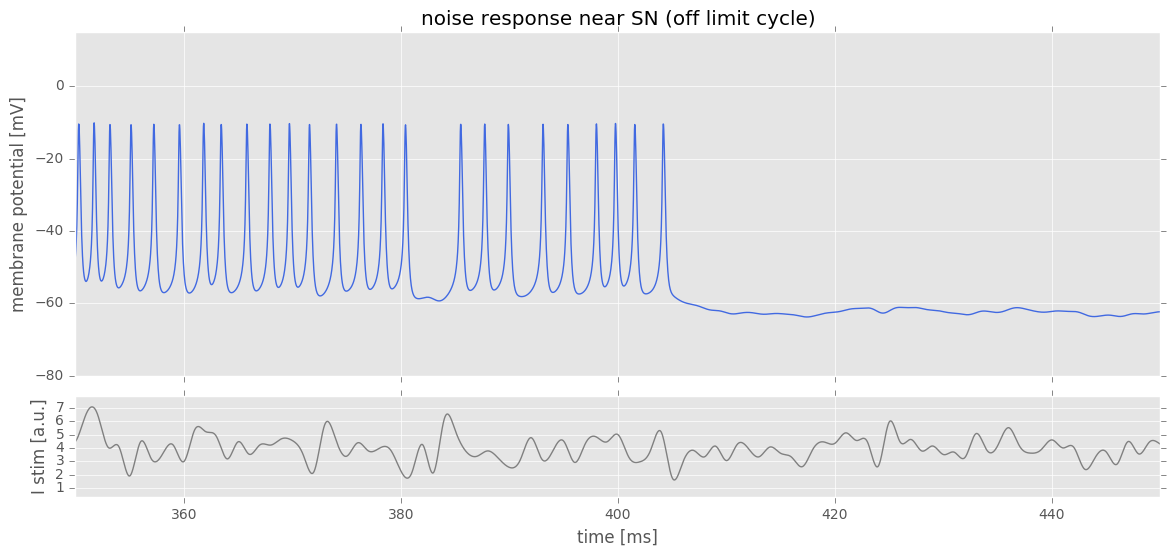

In [37]:

plot_with_i_dyn(snoff_neuron, init_state_snoff, i_stim_noise,tstop=999,
                title='noise response near SN (off limit cycle)')
#gcf().axes[1].set_ylim(2,6)
for ax in gcf().axes:
    ax.set_xlim(350,450)


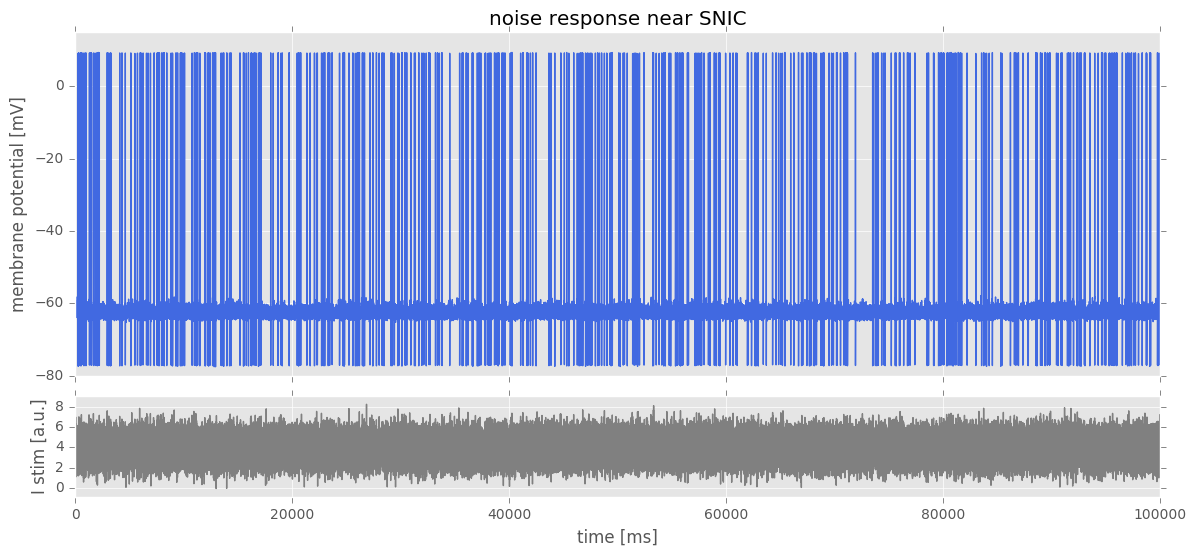

In [52]:
snic_neuron.I_bias=3.9

_,traj = adams_bashforth(snic_neuron, init_state,tstop=200)
init_state_snic = traj[-1]


plot_with_i_dyn(snic_neuron, init_state_snic, i_stim_noise,tstop=100000-1,
                title='noise response near SNIC')
#gcf().axes[1].set_ylim(2,6)

[-52.75630438   0.07234178]


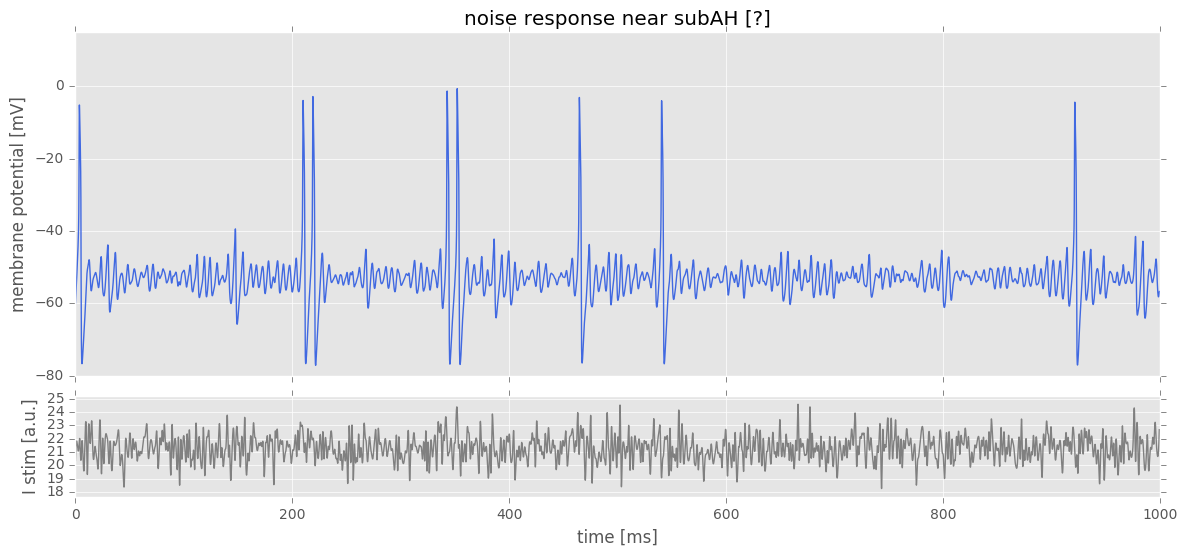

In [39]:
subAH_neuron.I_bias=21.2

_,traj = adams_bashforth(subAH_neuron, init_state,tstop=200)
init_state_subAH = traj[-1]
print init_state_subAH

plot_with_i_dyn(subAH_neuron, init_state_subAH, i_stim_noise,tstop=999,
                title='noise response near subAH [?]')
#gcf().axes[1].set_ylim(2,6)

[-50.40666233   0.25325393]


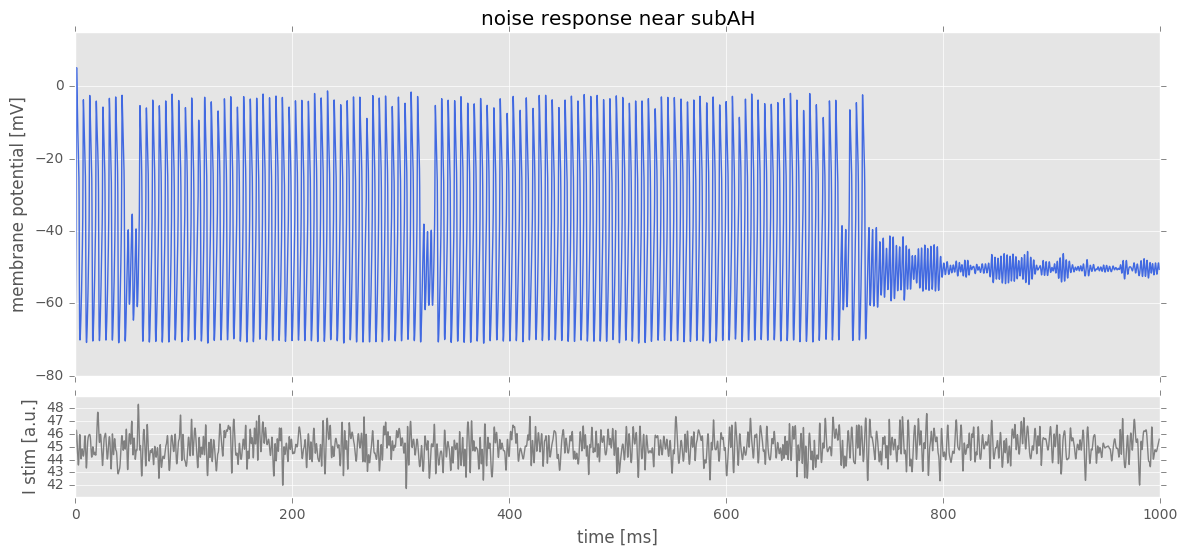

In [42]:
subAH2_neuron.I_bias=45.

_,traj = adams_bashforth(subAH2_neuron, [-50.6,0.2459],tstop=200)
init_state_subAH = traj[-1]
print init_state_subAH

plot_with_i_dyn(subAH2_neuron, init_state_subAH, i_stim_noise,tstop=999,
                title='noise response near subAH')
#gcf().axes[1].set_ylim(2,6)

[-57.48985388   0.11774341]


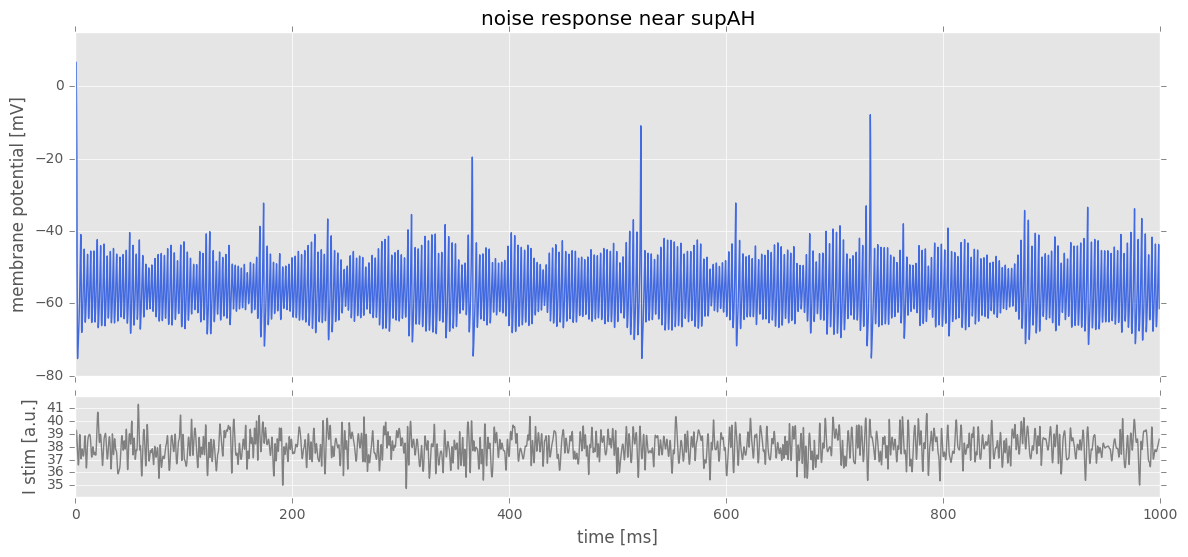

In [43]:
supAH2_neuron.I_bias=38

_,traj = adams_bashforth(supAH2_neuron, init_state,tstop=200)
init_state_supAH = traj[-1]
print init_state_supAH


plot_with_i_dyn(supAH2_neuron, init_state_supAH, i_stim_noise,tstop=999,
                title='noise response near supAH')

## Response to steps

In [44]:

from imfun import ui

Can't load OpenCV python bindings No module named cv2


In [45]:
def calc_steps(neuron, modifier = None):
    acc = []
    Vrest = -65
    if modifier is None:
        modifier={}
    iamps = Ibias_bif*1.01 + logspace(0, 6,5,base=2)-1
    
    ib = neuron.I_bias
    neuron.I_bias = 0
    

    for iamp in iamps:
        #print iamp
        Iapp = usp(tx, I_pulse(tx, iamp, 50, 550),s=0)
        pars = dict(I_dyn=Iapp)
        nrest = neuron.ninf(Vrest)
        st_init = array([Vrest, nrest])
        tvx, outx = adams_bashforth(neuron, st_init, fnkwargs=pars, tstop=600)
        acc.append(outx[:,0])
    
    neuron.I_bias = ib
    return tvx,array(acc),iamps

    
               

In [46]:
tvx,resp_1,iamps = calc_steps(snic_neuron)
tvx,resp_2,iamsp = calc_steps(supAH_neuron)

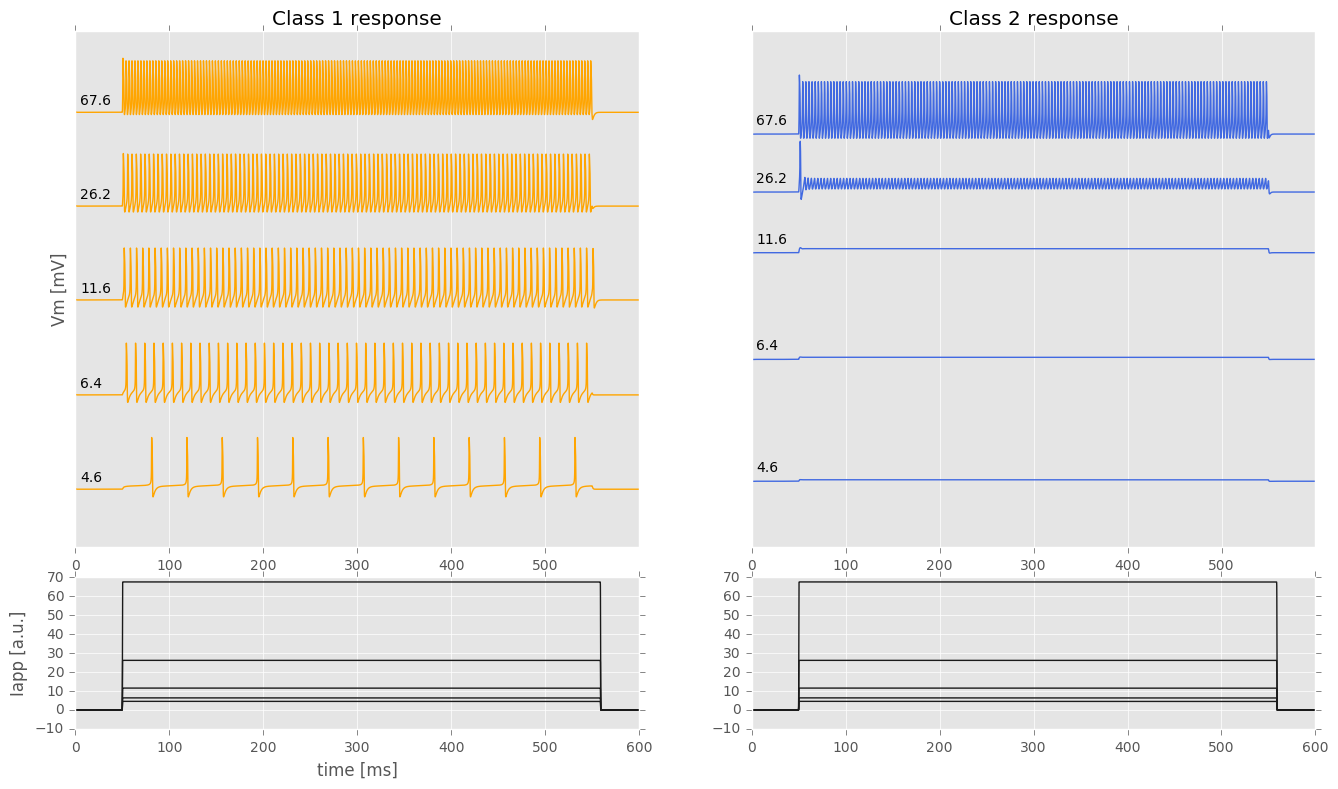

In [47]:
#f, axs = subplots(2,1,sharex=True,figsize=(16,12))

figure(figsize=(16,9))
ax1 = plt.subplot2grid((4,2), (0,0), rowspan=3)
ax2 = plt.subplot2grid((4,2),(3,0),)

ax3 = plt.subplot2grid((4,2), (0,1), rowspan=3)
ax4 = plt.subplot2grid((4,2),(3,1),)


labels=['%1.1f'%i for i in iamps]

ui.plot_coll(resp_1[::-1], x=tvx,ax=ax1,frame_on=True,colors='orange',sep=50)
ui.plot_coll(resp_2[::-1], x=tvx,ax=ax3,frame_on=True,colors='royalblue',sep=70)

setp(ax1, ylim = (-150, 600), ylabel='Vm [mV]', title='Class 1 response')
setp(ax3, ylim = (-150, 500), title='Class 2 response')

setp(ax2, xlabel='time [ms]', ylabel = 'Iapp [a.u.]')

#ax1.legend()

for line,label in zip(ax1.lines,labels[::-1]):
    yl = line.get_ydata()[0]
    ax1.text(5, yl+10, label)

for line,label in zip(ax3.lines,labels[::-1]):
    yl = line.get_ydata()[0]
    ax3.text(5, yl+10, label)
    

for i in iamps:
    y = usp(tx, I_pulse(tx, i, 50, 559),s=0)
    
    ax2.plot(tvx, y(tvx),color=(0.1,0.1,0.1))
    ax4.plot(tvx, y(tvx),color=(0.1,0.1,0.1))
#ylim(-1,55)

savefig('outputs/class1-2-responses-inapk.png')
savefig('outputs/class1-2-responses-inapk.svg')

In [363]:
def find_spiking_freq(neuron,Iv,T_cut = 500):
    acc = []
    _,traj = adams_bashforth(neuron, [-60,0.5], tstop=100)
    init_state = traj[-1]
    ib = neuron.I_bias
    for i in Iv:
        neuron.I_bias = i
        tvx_, outx_ = adams_bashforth(neuron, init_state,tstop=1000)
        v = outx_[:,0]
        kk = locmax(v)
        tlocs = array([tvx_[k] for k in kk])
        
        if len(tlocs) and any(tlocs>T_cut):
            ff = 1000./mean(diff(tlocs[tlocs>T_cut]))
        else:
            ff = 0
        #print i, len(tlocs), min(tlocs),max(tlocs)
        acc.append(ff)
    neuron.I_bias = ib
    return array(acc)
    

In [357]:
tx = linspace(0,1000,200)
Iv = 4 + 0.005*(tx-50)*I_pulse(tx, 1, 50, 4000)
%time ffv = find_spiking_freq(snic_neuron, Iv)

CPU times: user 1min 55s, sys: 48 ms, total: 1min 55s
Wall time: 1min 55s


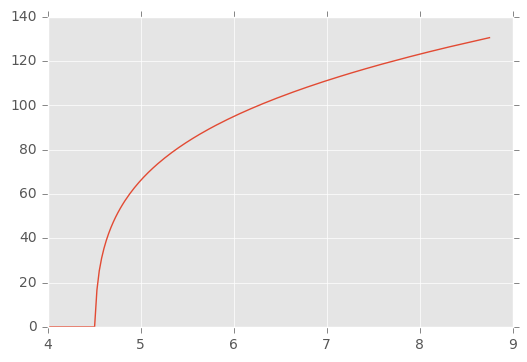

In [358]:
plot(Iv, ffv)

In [361]:
snic_neuron.I_bias = 0

(0, 150)

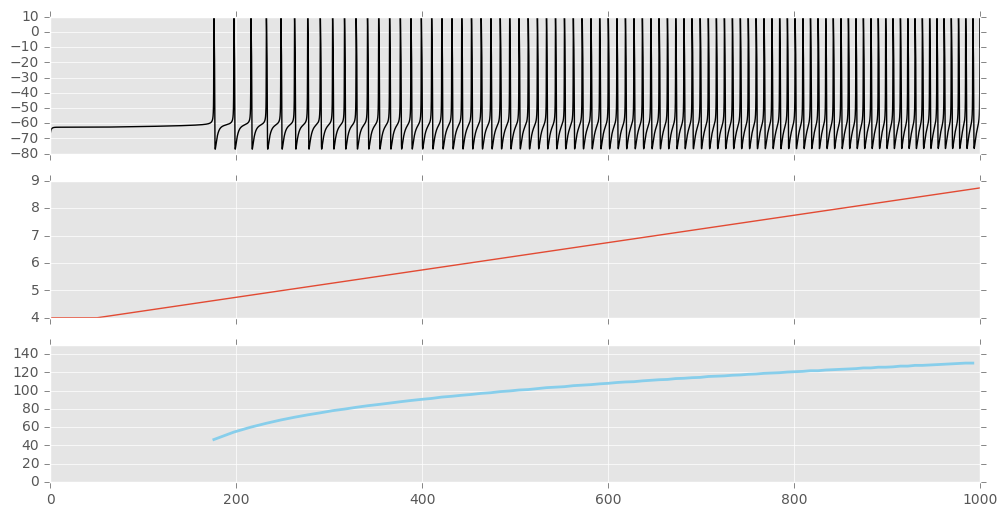

In [374]:
f, axs = subplots(3,1,figsize=(12,6), sharex=True)


tvx, outx = adams_bashforth(snic_neuron, [-65, 0.5],tstop=100)
init_state = outx[-1]

tvx, outx = adams_bashforth(snic_neuron, init_state, tstop=1000, fnkwargs=dict(I_dyn=usp(tx, Iv,s=0)))

V = outx[:,0]
axs[0].plot(tvx, V, color='black')
axs[1].plot(tx,Iv)

tlocs = [tvx[k] for k in locmax(V)]
ffv2 = 1000./diff(tlocs)


axs[2].plot(tlocs[:-1], ffv2,'-',color='skyblue',lw=2)
ylim(0,150)

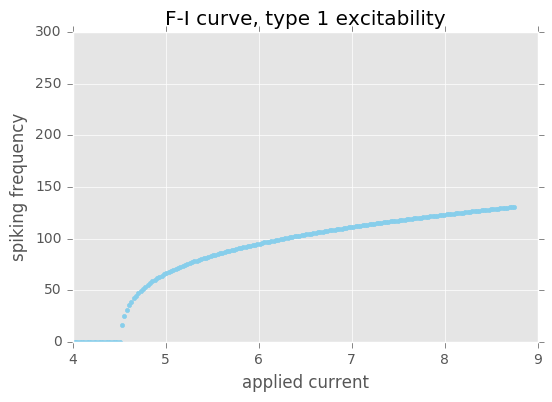

In [375]:
plot(Iv, ffv,'.',color='skyblue',)
#axs[2].plot(tlocs[:-1], ffv2,'.',color='skyblue',)
ylim(0,300)
xlabel('applied current')
ylabel('spiking frequency')
title("F-I curve, type 1 excitability")
savefig('outputs/F-I_curve_class1-inapk.svg')

In [411]:
#pars = dict(I_bias=6,I_kramp=0.05)

Iv2 = 4 + 0.05*(tx-10)*I_pulse(tx, 1, 10, 4000)

supAH_neuron.I_bias = 0

stim = usp(tx, Iv2+0.05*randn(len(tx)),s=0)

tvx1, outx1 = adams_bashforth(snic_neuron, init_state, fnkwargs=dict(I_dyn=stim),tstop=1000)
tvx2, outx2 = adams_bashforth(supAH_neuron, init_state, fnkwargs=dict(I_dyn=stim),tstop=1000)

61


(0, 300)

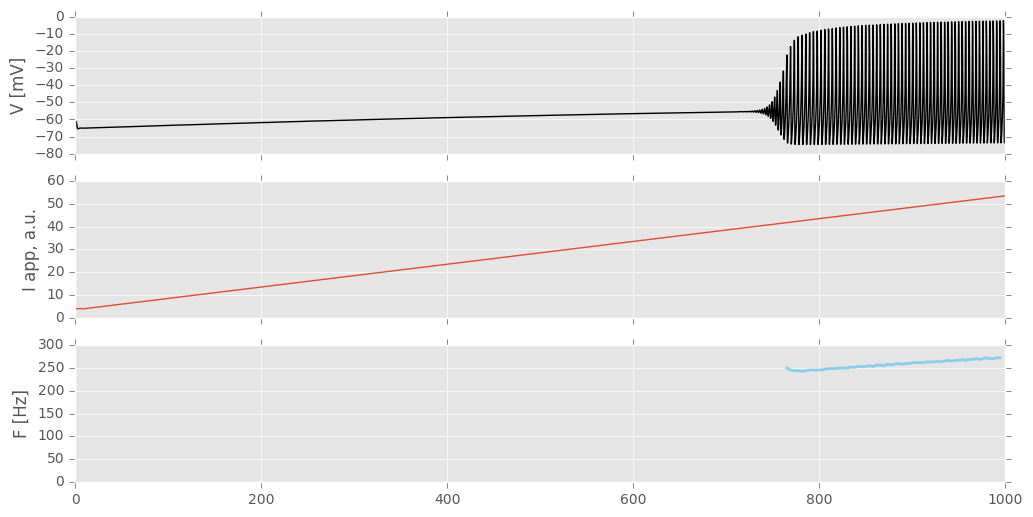

In [410]:
f, axs = subplots(3,1,figsize=(12,6), sharex=True)

V = outx2[:,0]
axs[0].plot(tvx2, V, color='black')
axs[1].plot(tx,Iv2)

axs[0].set_ylabel('V [mV]')
axs[1].set_ylabel('I app, a.u.')
axs[2].set_ylabel('F [Hz]')



tlocs = [tvx2[k] for k in locmax(V,-30)]
print len(tlocs)
ffvx = 1000./diff(tlocs)


axs[2].plot(tlocs[:-1], ffvx,'-',color='skyblue',lw=2)
ylim(0,300)

In [413]:
%time ffv2 = find_spiking_freq(supAH_neuron, Iv2)
%time ffv3 = find_spiking_freq(snic_neuron, Iv2)

CPU times: user 1min 45s, sys: 24 ms, total: 1min 45s
Wall time: 1min 45s
CPU times: user 1min 35s, sys: 12 ms, total: 1min 35s
Wall time: 1min 35s


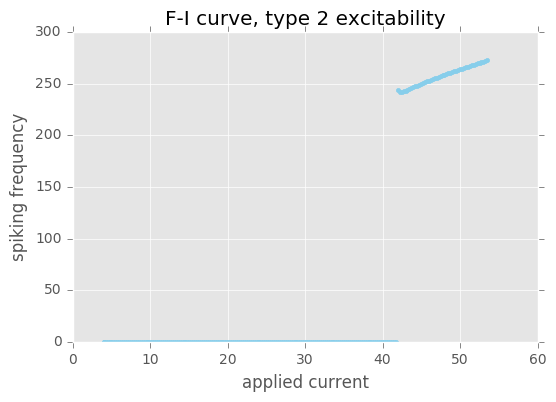

In [414]:
plot(Iv2, ffv2,'.',color='skyblue',)
#axs[2].plot(tlocs[:-1], ffv2,'.',color='skyblue',)
ylim(0,300)
xlabel('applied current')
ylabel('spiking frequency')
title("F-I curve, type 2 excitability")
savefig('outputs/F-I_curve_class2-inapk.svg')

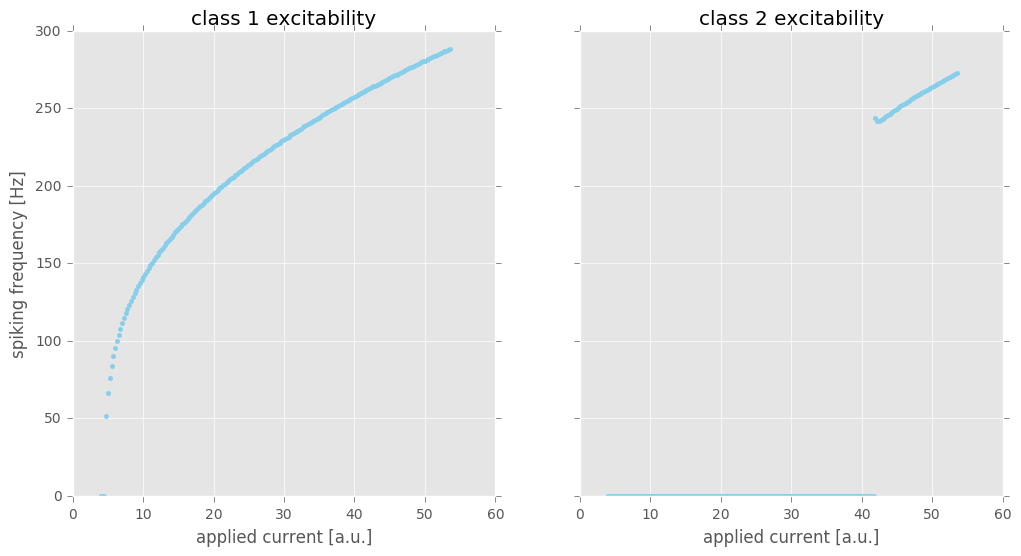

In [416]:
f, axs = subplots(1,2,sharey=True,sharex=True,figsize=(12,6))

axs[0].plot(Iv2, ffv3,'.',color='skyblue',)
axs[1].plot(Iv2, ffv2,'.',color='skyblue',)
#axs[2].plot(tlocs[:-1], ffv2,'.',color='skyblue',)
ylim(0,300)
axs[0].set_xlabel('applied current [a.u.]')
axs[1].set_xlabel('applied current [a.u.]')

axs[0].set_ylabel('spiking frequency [Hz]')
axs[0].set_title("class 1 excitability")
axs[1].set_title("class 2 excitability")
savefig('outputs/F-I_curves_both-inapk.svg')